# Notebook 4: Ising model - PCA
<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

## Learning goals

The goal of this notebook is to present an application of PCA to a physical problem. Specifically, we consider the Ising model and show that PCA can identify the order parameter of the model (the magnetisation). Under a critical temperature the system magnetises, above a certain temperature the system is disordered.

## The Ising model

The Ising model (named after the physicist Ernst Ising) is a mathematical model of ferromagnetism in statistical mechanics. The model consists of discrete variables that represent magnetic dipole moments of atomic "spins" that can be in one of two states (+1 or −1). The spins are arranged in a graph, usually a lattice (where the local structure repeats periodically in all directions), allowing each spin to interact with its neighbors. Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. The model allows the identification of phase transitions as a simplified model of reality. The two-dimensional square-lattice Ising model is one of the simplest statistical models to show a phase transition

The one-dimensional Ising model was solved by Ising (1925) alone in his 1924 thesis; it has no phase transition. The two-dimensional square-lattice Ising model is much harder and was only given an analytic description much later, by Lars Onsager (1944). Onsanger showed that the model undergoes a second-order phase transition for a value of the critical temperature 
$$T_c=\frac{2J}{\ln(1+\sqrt{2})}=2.269J.$$ 
For $T<T_c$, the system is magnetic (the state is ordered because of local spin interactions). For $T>T_c$, the system is paramagnetic (the state is disordered).

The Hamiltonian of the system is
$$\mathcal{H}=-J\sum_{\langle ij\rangle}S_iS_j$$
where the spin states $S_i$ can have values +1 or -1, $\langle ij\rangle$ denotes the interaction between the nearest neighbours, and $J>0$ is the strength of the itneraction.

Let us define the following quantities:
- mean magnetisation
$$ \langle M\rangle =\frac{1}{N}\sum_i S_i$$
- absolute mean magnetisation
$$ \left|\langle M\rangle\right| =\frac{1}{N}\left|\sum_i S_i\right|$$
- specific heat capacity
$$C=\frac{1}{N}\frac{1}{T}(⟨E^2⟩−⟨E⟩^2)$$
- magnetic susceptibility
$$
\chi=\frac{1}{N}\frac{1}{T}(⟨M^2⟩−⟨|M|⟩^2)
$$

## The Ising data set: initialisation and exploration

First of all, let us load the relevant libraries and data sets. The data set corresponds to 1024 different configurationsof the 2D Ising model on a $10\time 10$ lattice for 32 values of the temperature $T$. These comfigurations were generated with the [Metropolis algorithm](https://phas.ubc.ca/~berciu/TEACHING/PHYS503/PROJECTS/05_dominic.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

data = np.load(u'data/MC_Ising_2Dsquare_10x10.npz')

The format of the data is .npz. This is the numpy format for compressed data. Let us visualise the data.

In [2]:
data.files

['configs', 'temperatures']

Let us explore the data.

In [3]:
configs = data['configs']
T = data['temperatures']

For each value of $T$, let use display a random configuration from the data set.

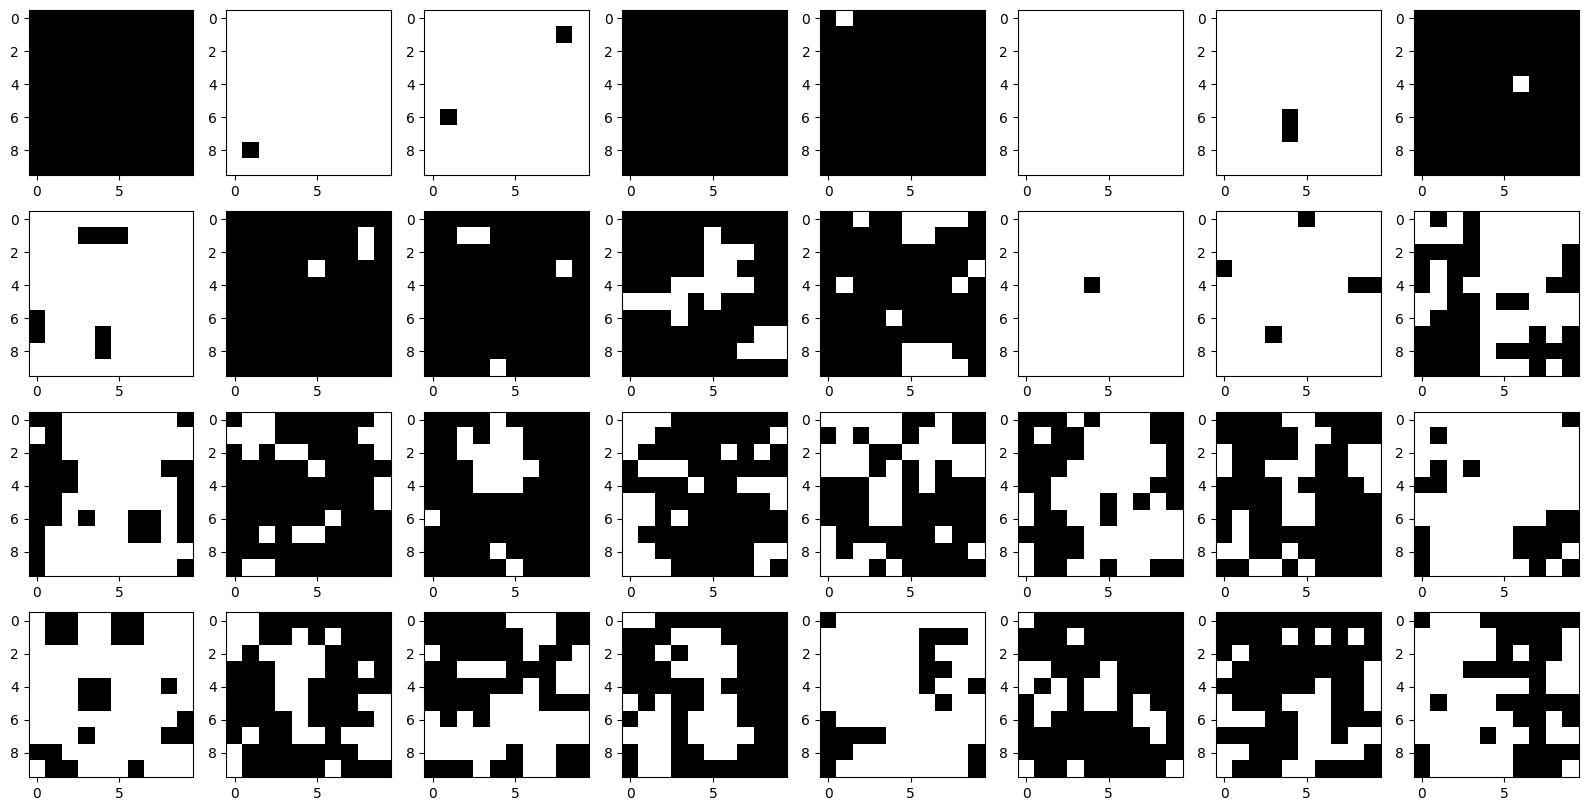

In [4]:
plt.figure(figsize=(20, 10))
for i in range(np.shape(T)[0]):
    j = np.random.randint(0, np.shape(configs)[1])
    plt.subplot(4, 8, i+1)
    plt.imshow(configs[i, j], cmap='Greys', vmin=-1, vmax=1)

Let us define some relevant physical quantities.

<>:55: SyntaxWarning: invalid escape sequence '\c'
<>:55: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_508091/431963833.py:55: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$|\chi|$')


Text(0.5, 1.0, 'Magnetic susceptibility')

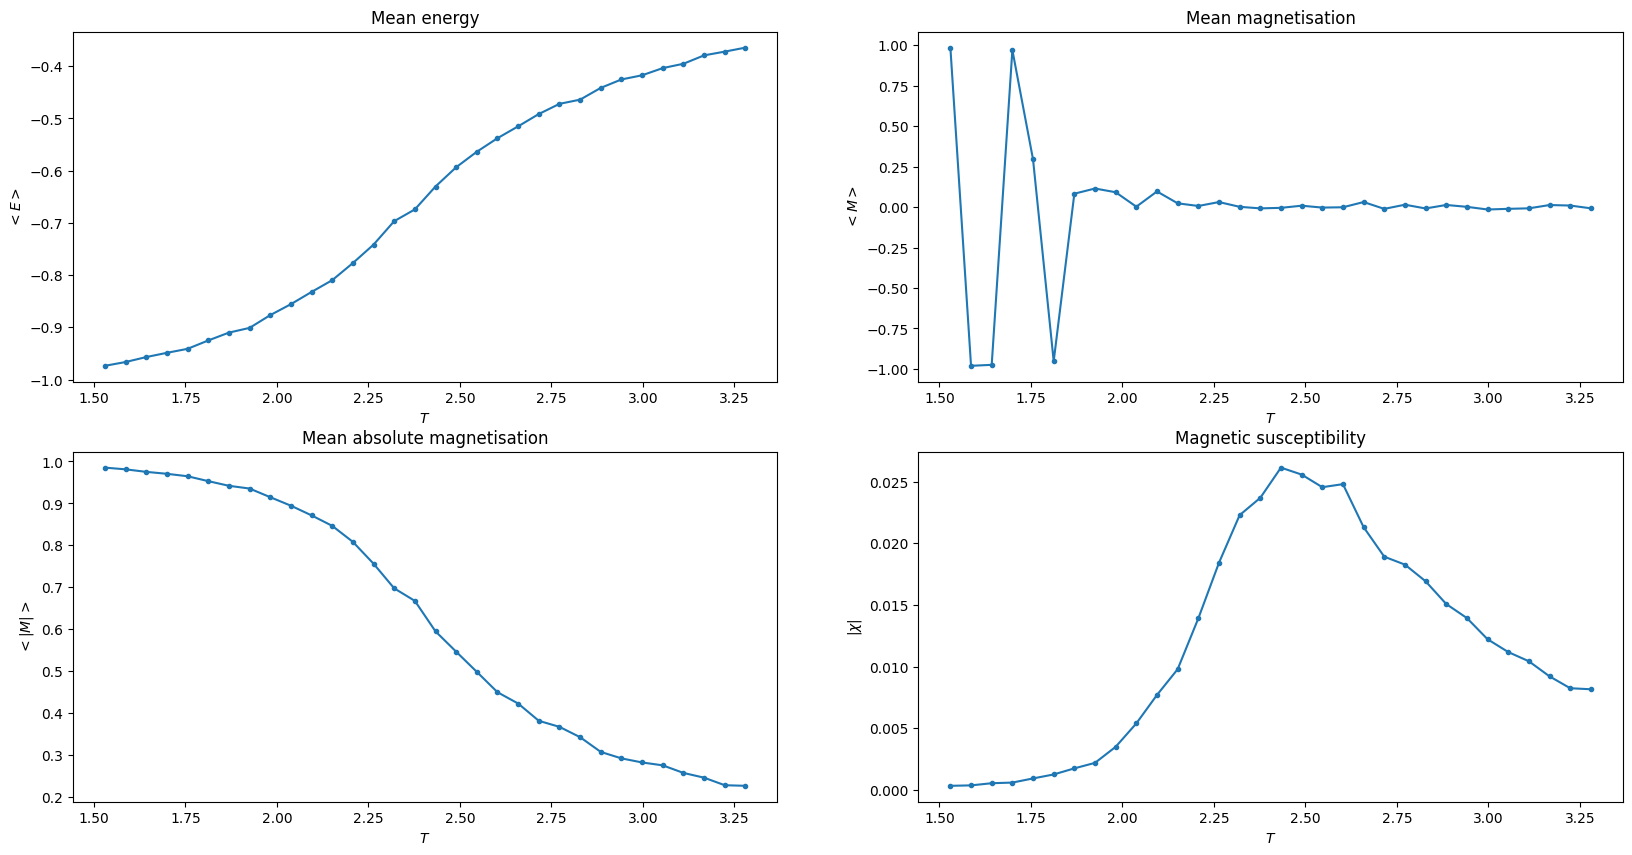

In [5]:
def calc_magnetization_and_susceptibility(configs):
    # the magnetization per configuration is given by the sum of all spins, here we take the absolute magnetization
    # sum over each configuration and normalize
    Mag = np.sum(configs, axis=(2, 3))
    Mag = np.divide(Mag, np.shape(configs)[2] * np.shape(configs)[3])
    AbsMag = np.abs(Mag)
    MagSq = np.square(AbsMag)
    #sum over configs per temperature
    Mag = np.sum(Mag, axis=1) / np.shape(configs)[1]
    AbsMag = np.sum(AbsMag, axis=1) / np.shape(configs)[1]
    MagSq = np.sum(MagSq, axis=1) / np.shape(configs)[1]
    Chi = np.divide(np.add(MagSq, -np.square(AbsMag)), T)
    return Mag, AbsMag, Chi

def calc_energy(configs):
    # the energy per configuration can be determined from the Hamiltonian
    Energy = np.zeros(np.shape(configs)[0])
    for t in range(np.shape(configs)[0]):
        En = 0
        for c in range(np.shape(configs)[1]):
            # For each configuration, calculate the energy by multiplying each site with its 
            # horizontal and vertical nearest neighbour and summing the total
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=0)))
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=1)))
        En /= 2 * np.shape(configs)[1] * np.shape(configs)[2] * np.shape(configs)[3]
        Energy[t] = En
    return Energy

Mag, AbsMag, Chi = calc_magnetization_and_susceptibility(configs)
Energy = calc_energy(configs)

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(T, Energy, '.-')
plt.xlabel('$T$')
plt.ylabel('$<E>$')
plt.title('Mean energy')

plt.subplot(2, 2, 2)
plt.plot(T, Mag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<M>$')
plt.title('Mean magnetisation')

plt.subplot(2, 2, 3)
plt.plot(T, AbsMag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<|M|>$')
plt.title('Mean absolute magnetisation')

plt.subplot(2, 2, 4)
plt.plot(T, Chi, '.-')
plt.xlabel('$T$')
plt.ylabel('$|\chi|$')
plt.title('Magnetic susceptibility')

## Principal componenet analysis

Let us manipulate the data.

In [6]:
configs_PCA = np.reshape(configs, (-1, np.shape(configs)[2] * np.shape(configs)[3]))
(n,m)=np.shape(configs_PCA)
z = np.zeros((n,m))

T_PCA = np.zeros((1,np.shape(configs)[0] * np.shape(configs)[1]))
module=np.zeros((len(T),np.shape(configs)[1]))
for i in range(len(T)):
    module[i]=np.tile(T[i],np.shape(configs)[1])
T_PCA=np.concatenate(module, axis=None)
print(np.shape(configs_PCA))
print(np.shape(T_PCA))

(32768, 100)
(32768,)


Let us centre the data.

In [7]:
configs_PCA_mean = np.mean(configs_PCA,axis=0)
for i in range(m):
    z[:,i]=(configs_PCA_mean[i]-configs_PCA[:,i])

Let us compute the covariance matrix.

In [8]:
cov = np.cov(z,rowvar=False)

Let us find its eigenvectors and eigenvalues

In [9]:
eigensystem=np.linalg.eig(cov)

Let us visualise the eigenvalues from the largest to the smallest.

Text(0.5, 1.0, 'Eigenvectors of the covariance matrix')

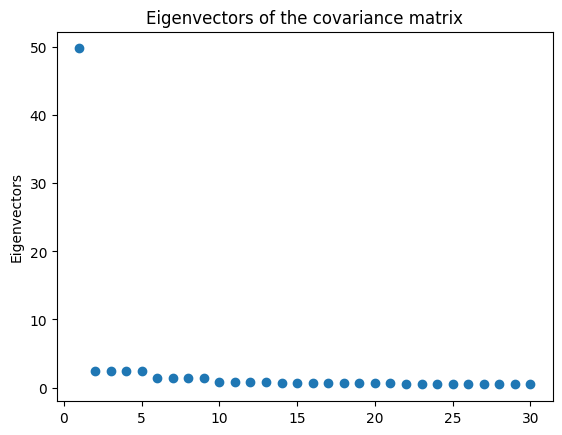

In [10]:
n = []
for i in range(1,m+1):
  n.append(i)
plt.scatter(n[0:30],eigensystem[0][0:30])
plt.ylabel("Eigenvectors")
plt.title("Eigenvectors of the covariance matrix")

Let us project the data on the two first principal components.

In [11]:
def reduce_system(U,dimension):
    U_reduced=U[ : , :dimension]
    reduced_vec=np.dot(z,U_reduced)
    var=np.sum(eigensystem[0][:dimension])/np.sum(eigensystem[0][:])
    return reduced_vec,var

reducevec, vari = reduce_system(eigensystem[1],2)

Let us visualise the results.

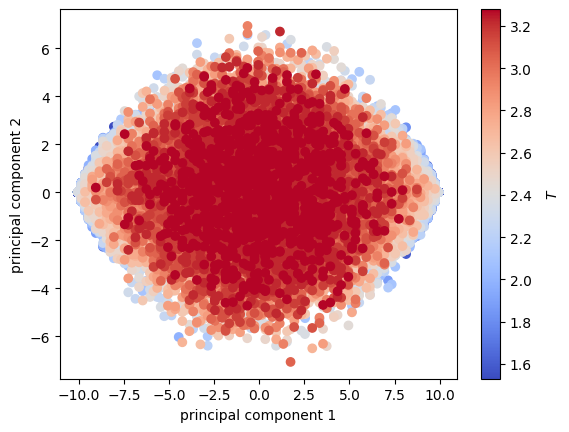

In [12]:
plt.scatter(reducevec[:,0],reducevec[:,1],c=T_PCA,cmap="coolwarm") 
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)

The same result can be readily obtained with [scikit-learn](https://scikit-learn.org/stable/).

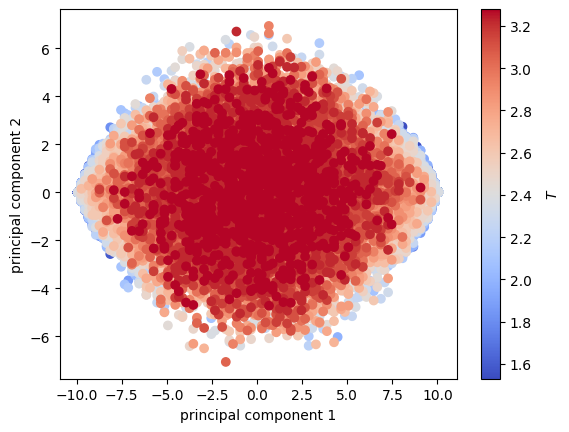

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(configs_PCA)
plt.scatter(principalComponents[:,0],principalComponents[:,1],c=T_PCA,cmap="coolwarm") 
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)
plt.show()